# Student_exam_oriented_ex_7_2

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [2]:
#!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [3]:
import numpy as np
from local.lib.data import load_data
import scipy as sc
import matplotlib.pyplot as plt

In [4]:
#!pip install cvxpy

In [5]:
import cvxpy as cp

## Exercise


- Algorithm: Distributed ADMM
- Problem: Binary classification using SVM

$$\underset{{\bf{w}}}{\arg\min}f({\bf{w}})=\underset{{\bf{w}}\in\mathbb{R}^{d+1}}{\textrm{ arg min}}\left(\frac{1}{n}\sum_{i=1}^n\textrm{max}\left(1-y_{i}\left({\bf{w}}^{T}{\bf{x}}_{i}\right),0\right)+\frac{\lambda}{2}\left\Vert {\bf{w}}\right\Vert _{2}^{2}\right)$$

- Breast cancer dataset
    - 10 features: ID of patient and biological properties of the tumor.
        - We use 8 features: $\bf{X}$ is a $500\times 8$ matrix containing 500 dataset entries.
    - Target: to classify the tumor as malign or benign.
        -  Thus, ${\bf{y}}$ is a $500\times1$ vector containing the labels
        - Note that the medical record is a sensitive information that we do not want to share among nodes; we use distributed ADMM to train the classifier without exchanging the data (privacy preserving).

**Some hints**

We assume that each $j$-th worker has its own set of data samples, so the function we want to solve is:

$$\underset{\{{\bf{w}}_j\}_{j=1}^{n_b}, {\bf{z}}}{\arg\min}\left( \sum_{j=1}^{n_b} \frac{1}{n}\sum_{i=1}^m\textrm{max}\left(1-y_{j,i}\left({\bf{w}}_j^{T}{\bf{x}}_{j,i}\right),0\right)+\frac{\lambda}{2}\left\Vert {\bf{z}}\right\Vert _{2}^{2}\right)$$
$$
\text{s.t.}\, {\bf{w}}_j - {\bf{z}} = 0
$$

The augmented Lagrangian is:

$$
\begin{array}{c}
L_{\rho}\left(W,{\bf{z}},\beta_{j}\right)=\sum_{j=1}^{n_b}\Big(\frac{1}{n}\sum_{i=1}^{m}\max\big(1-y_{j,i}{\bf{w}}_j^T {\bf{x}}_{j,i},0\big)\Big)+\frac{\lambda}{2}\left\Vert {\bf{z}} \right\Vert _{2}^{2}\\
\quad\quad+\sum_{j=1}^{n_b} \beta_{j}^{T}\left({\bf{w}}_{j}-{\bf{z}}\right)+\sum_{i=1}^{n_b}\frac{\rho}{2}\left\Vert {\bf{w}}_{j}-{\bf{z}}\right\Vert _{2}^{2}
\end{array}
$$

So, the subgradient of $L_{\rho}$ with respect to ${\bf{w}}_j$ is:

$$
g({\bf{w}}_j)=\beta_j + \rho({\bf{w}}_j - {\bf{z}}) + \frac{1}{n}\sum_{i=1}^m \begin{cases}
\begin{array}{c}
0\\
-y_{j,i}{\bf{x}}_{j,i}
\end{array} & \begin{array}{c}
if\,\,y_{j,i}{\bf{w}}_j^T{\bf{x}}_{j,i}>1\\
if\,\,y_{j,i}{\bf{w}}_j^T{\bf{x}}_{j,i}<1
\end{array}\end{cases}\label{eq:subgrad_svm_expression}
$$

Since in this case is not possible to isolate ${\bf{w}}_j$ you must use a subgradient update for updating ${\bf{w}}_j$, and run it for a given number of iterations.

**Note** that we are assuming all the workers have access to the same number of samples ($m$).

In [6]:
#load data
X,y = load_data("classification", 7)
n,d = X.shape

In [7]:
# Constant parameters
lamb = 0.01   # regularisation parameter
Niter= 3000   # Number of iterations for each algorithm
eta = 0.001   # step size 

In [8]:
#cvx_solver
def solver_cvx(n,X,Y,lamb,objective_fn):
    n_columns = X.shape[1]
    w = cp.Variable(n_columns)
    lambd = cp.Parameter(nonneg=True)
    lambd.value = lamb
    problem = cp.Problem(
        cp.Minimize(objective_fn(n, X, Y, w, lambd))
    )
    problem.solve()
    return w.value

In [9]:
# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.sum(cp.pos(1-cp.multiply(Y,X @ w)))
reg_L2 = lambda w: cp.pnorm(w, p=2)**2
loss_svm_L2 = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + (lambd/2) * reg_L2(w)

# Solution of the empirical risk using CVX
w_svm_cvx=solver_cvx(n,X,y,lamb,loss_svm_L2)

w = cp.Variable(w_svm_cvx.shape[0])
w.value = w_svm_cvx
f_cvx=loss_svm_L2(n,X,y,w_svm_cvx,lamb).value

print(f'The loss function f at the optimum takes the value {f_cvx}')

f_cvx = (np.kron(f_cvx,np.ones((1,Niter+1)))).flatten()

The loss function f at the optimum takes the value 0.42642274201112185


In [10]:
#Function that estimates the loss for several w at once.
f = lambda n, X, Y, w, lambd: (1/n)*np.sum(np.maximum(np.zeros((n,w.shape[1])),np.ones((n,w.shape[1]))-np.diag(Y)@(X@w)),axis=0) + (lambd/2)*np.sum(w**2,axis=0)

In [76]:
# Distributed ADMM

#Constants
ro=1               # Quadratic term
nb=4               #Number of nodes (to split samples)
m = int(n/nb)      #Number of samples per node
subgrad_steps = 10 #Number of gradient steps per ADMM update


w_admm_d = np.zeros((nb,d,Niter+1))
b_admm_d = np.zeros((nb,d,Niter+1))
z_admm_d = np.zeros((d,Niter+1))

for k in range(Niter):
    #Complete the code including the updating formulas for centrilized ADMM. 
    # Keep the weigths values for all the iterations
    
    # This loop simulates the processing to execute in every node
    for j in range(nb):
        Xj = X[j*m:(j+1)*m,:] #Input Samples observed by node j
        yj = y[j*m:(j+1)*m]   #Target values of the corresponding samples. 
        
        
        #Update w_j,k+1---------------
        for _ in range(subgrad_steps):
            subgrad = ...
    
        w_admm_d[j][:,k+1] = ...
    
    
    # Update z_k+1------------------
    
    z_admm_d[:,k+1] = ....
    
    # Update beta_k+1
    
    b_admm_d[:,:,k+1] = ...

f_admm_d=f(n,X,y,z_admm_d,lamb)

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
t = range(Niter+1)
plt.plot(t, 10*np.log10((f_admm_d-f_cvx)**2+np.finfo(float).eps), color = 'r',label = 'Distributed ADMM')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'$10\log(f({\bf{x}})-f*)^2)$ (MSE)')
plt.show()

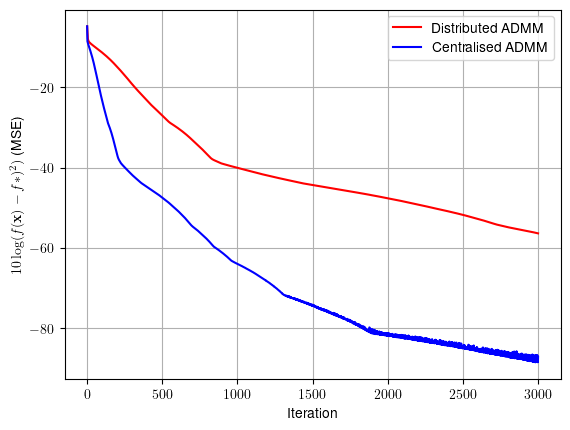